In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

## Parâmetros

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_path = os.path.join(os.path.curdir, 'dataset')
train_test_ratio = 0.8
img_size = (128, 128)
batch_size = 32
num_epochs = 4

## Carregar Dataset

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class GoogleDriveDataset(Dataset):
    def __init__(self, url, transform = None):
        self.url = url
        self.transform = transform

        self.samples = []   # [(image_path: string, label: string)]
        self.class_name_to_id = {} # {class_name: string -> id: number}
        
        for class_id, class_name in enumerate(sorted(os.listdir(url))):
            self.class_name_to_id[class_name] = class_id

            class_path = os.path.join(url, class_name)
            for file_name in os.listdir(class_path):
                self.samples.append((
                    os.path.join(class_path, file_name),
                    class_id
                ))

    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_path, label = dataset.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
dataset = GoogleDriveDataset(
    dataset_path, 
    transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
)

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [
        int(train_test_ratio * len(dataset)), 
        len(dataset) - int(train_test_ratio * len(dataset))
    ]
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, len(test_dataset), shuffle=True)

## Definir Rede Neural

In [15]:
class Cnn(nn.Module):
    def __init__(self, input_size, out):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.maxPool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 5, 5)
        l1w = (((input_size[0] - self.conv1.kernel_size[0] + 1) // 2 - self.conv2.kernel_size[0] + 1) // 2)
        l1h = (((input_size[1] - self.conv1.kernel_size[0] + 1) // 2 - self.conv2.kernel_size[0] + 1) // 2)
        print(f'[CNN] conv out dim: {l1w} x {l1h}')
        self.l1 = nn.Linear(l1w * l1h * 5, 120)
        self.l2 = nn.Linear(self.l1.out_features, 80)
        self.l3 = nn.Linear(self.l2.out_features, out)
        nParams = 0
        for p in self.parameters():
            nParams += p.data.view(-1).size()[0]
        print(f'[CNN] params count: {nParams}')
    
    def forward(self, x):
        x = self.maxPool(F.relu(self.conv1(x)))
        x = self.maxPool(F.relu(self.conv2(x)))
        x = x.view(-1, self.l1.in_features)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [16]:
cnn = Cnn(img_size, 5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters())

[CNN] conv out dim: 29 x 29
[CNN] params count: 515815


## Treinar

In [19]:
lossi = []

In [55]:
for epoch in range(100):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        lossi.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000:
            print(f'loss = {loss.data}')

loss = 0.18016968667507172
loss = 0.037545643746852875
loss = 0.08142722398042679
loss = 0.07167027145624161
loss = 0.054023440927267075
loss = 0.1382872611284256
loss = 0.06641381978988647
loss = 0.10064263641834259
loss = 0.0769934132695198
loss = 0.019613323733210564
loss = 0.0507371723651886
loss = 0.060588400810956955
loss = 0.05316924676299095
loss = 0.05277223512530327
loss = 0.0677890032529831
loss = 0.029883351176977158
loss = 0.03902112692594528
loss = 0.05363256484270096
loss = 0.06559138745069504
loss = 0.1565445065498352
loss = 0.11066371202468872
loss = 0.03705413267016411
loss = 0.007553503382951021
loss = 0.2904875874519348
loss = 0.03262303024530411
loss = 0.08725637197494507
loss = 0.016390062868595123
loss = 0.04475059360265732
loss = 0.01857193373143673
loss = 0.01737755350768566
loss = 0.028062019497156143
loss = 0.019518796354532242
loss = 0.03485482186079025
loss = 0.01427729893475771
loss = 0.011444568634033203
loss = 0.021482177078723907
loss = 0.01649796403944

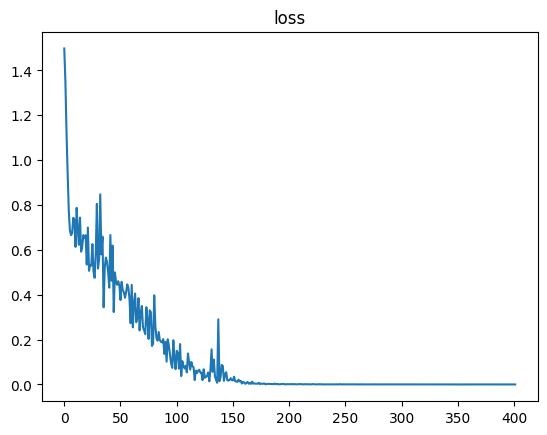

In [63]:
plt.title('loss')
plt.plot(lossi)

In [ ]:
print(f'Última taxa de acerto no treino registrada: {10**(-lossi[-1].item() + 2)}%')

Final train accuracy: 99.967638290912%


## Teste

In [72]:
with torch.no_grad():
    n_correct = 0
    for images, labels in test_loader:
        outputs = cnn(images)
        _, pred = torch.max(outputs, 1)
        n_correct += (pred == labels).sum().item()
    
    accuaracy = n_correct / len(test_dataset) * 100
    print(f'Taxa de acerto nos testes: {n_correct} / {len(test_dataset)} ({accuaracy}%)')

Taxa de acerto nos testes: 17 / 20 (85.0%)
